In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import numpy as np
import heapq
from operator import itemgetter
import numpy.linalg as LA
import xml.etree.ElementTree as et, pandas as pd, re
from bs4 import BeautifulSoup

In [2]:
xtree = et.parse('Posts.xml')

xroot = xtree.getroot()

dfCols = ["Closed Date", "Favorite Count", "Comment Count", "Answer Count", "Tags", "Title",
          "Last Activity Date", "Owner User ID", "Body", "View Count", "Score", "Creation Date", "Post Type ID", 
          "ID", "Parent ID", "Last Edit Date", "Last Editor User ID", "Accepted Answer ID"]
dfRows = []

In [3]:
for node in xroot:
    closedDate = node.attrib.get("ClosedDate")
    favCount = node.attrib.get("FavoriteCount")
    commentCount = node.attrib.get("CommentCount")
    ansCount = node.attrib.get("AnswerCount")
    tags = node.attrib.get("Tags")
    title = node.attrib.get("Title")
    lastActDate = node.attrib.get("LastActivityDate")
    ownerUserID = node.attrib.get("OwnerUserId")
    body = node.attrib.get("Body")
    viewCount = node.attrib.get("ViewCount") 
    score = node.attrib.get("Score") 
    creationDate = node.attrib.get("CreationDate") 
    postTypeID = node.attrib.get("PostTypeId") 
    ID = node.attrib.get("Id") 
    parentID = node.attrib.get("ParentId") 
    lastEditDate = node.attrib.get("LastEditDate") 
    lastEditorUserID = node.attrib.get("LastEditorUserId") 
    acceptedAnswerID = node.attrib.get("AcceptedAnswerID")
    
    dfRows.append({"Closed Date": closedDate, "Favorite Count": favCount, "Comment Count": commentCount,
                     "Answer Count": ansCount, "Tags": tags, "Title": title, "Last Activity Date": lastActDate,
                     "Owner User ID": ownerUserID, "Body": body, "View Count": viewCount, "Score": score, 
                    "Creation Date": creationDate, "Post Type ID": postTypeID, "ID": ID, "Parent ID": parentID,
                    "Last Edit Date": lastEditDate, "Last Editor User ID": lastEditorUserID, "Accepted Answer ID": acceptedAnswerID})

In [4]:
out = pd.DataFrame(dfRows, columns=dfCols)

out = out.fillna(0)

out['Creation Date'] = pd.to_datetime(out['Creation Date'])
out['Creation Date'] = out['Creation Date'].dt.strftime('%Y/%m/%d')
out['Comment Count'] = out['Comment Count'].astype(int)
out['Owner User ID'] = out['Owner User ID'].astype(int)
out['Post Type ID'] = out['Post Type ID'].astype(int)
out['ID'] = out['ID'].astype(int)
out['Score'] = out['Score'].astype(int)
out['Favorite Count'] = out['Favorite Count'].astype(int)
out['Answer Count'] = out['Answer Count'].astype(int)
out['View Count'] = out['View Count'].astype(int)

answers = out[(out['Post Type ID'] == 1)]

answers = answers[['ID','Creation Date','Tags','Title','Body']]

#words kolonu title ile bodynin birleşmiş hali, 
answers['Words'] = answers[['Title', 'Body']].apply(lambda x: ' '.join(x), axis=1)

answers.head

<bound method NDFrame.head of           ID Creation Date                                               Tags  \
0          1    2016/08/02  <neural-networks><backpropagation><terminology...   
1          2    2016/08/02  <neural-networks><machine-learning><statistica...   
3          4    2016/08/02                    <deep-network><search><neurons>   
4          5    2016/08/02                               <python><mindstorms>   
5          6    2016/08/02       <philosophy><definitions><intelligent-agent>   
6          7    2016/08/02                                <intelligent-agent>   
9         10    2016/08/02           <deep-network><terminology><fuzzy-logic>   
12        13    2016/08/02               <neural-networks><image-recognition>   
14        15    2016/08/02  <turing-test><strong-ai><intelligent-agent><we...   
15        16    2016/08/02  <deep-learning><definitions><overfitting><regu...   
16        17    2016/08/02  <philosophy><definitions><agi><superintelligen...  

In [5]:
answers.Words

0        What is "backprop"? <p>What does "backprop" me...
1        How does noise affect generalization? <p>Does ...
3        How to find the optimal number of neurons per ...
4        How to program AI in Mindstorms <p>I have a LE...
5        Are humans intelligent according to the defini...
6        Why does Stephen Hawking say "Artificial Intel...
9        What is fuzzy logic? <p>I'm new to A.I. and I'...
12       Can a single neural network handle recognizing...
14       Is the Turing Test, or any of its variants, a ...
15       What is "early stopping" in machine learning? ...
16       What is the concept of the technological singu...
20       What are the methods of optimizing overfitted ...
25       How could emotional intelligence be implemente...
27       Is a genetic algorithm an example of artificia...
33       What is the difference between artificial inte...
34       To what extent can quantum computers help to d...
35       What is a Markov chain and how can it be used .

In [6]:
size = len(answers.ID.to_list())

In [7]:
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()
transformer = TfidfTransformer()

In [8]:
id_set = answers.ID.to_list()[:size] #Documents
test_set = answers.Words.to_list()[4068:] #Query
trainVectorizerArray = vectorizer.fit_transform(answers.Words.to_list()[:4068]).toarray() #Documents
testVectorizerArray = vectorizer.transform(test_set).toarray()

In [9]:
cx = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 3)
cosineResultDict = {}
bestVector = []
for index in range(len(trainVectorizerArray)):
    vector = trainVectorizerArray[index]
    for j in range(0,len(testVectorizerArray)):
        testV = testVectorizerArray[j]
        cosine = cx(vector, testV)
        bestVector.append(cosine)
        if id_set[4068+j] in cosineResultDict.keys():
            cosineResultDict[int(id_set[4068+j])].append((int(index),cosine))
        else:
            cosineResultDict[int(id_set[4068+j])] = [(int(index),cosine)]


In [10]:
cosineResultDict[int(id_set[4068+500])]

[(0, 0.088),
 (1, 0.06),
 (2, 0.153),
 (3, 0.103),
 (4, 0.077),
 (5, 0.113),
 (6, 0.176),
 (7, 0.151),
 (8, 0.063),
 (9, 0.118),
 (10, 0.11),
 (11, 0.223),
 (12, 0.167),
 (13, 0.07),
 (14, 0.196),
 (15, 0.155),
 (16, 0.074),
 (17, 0.102),
 (18, 0.0),
 (19, 0.162),
 (20, 0.019),
 (21, 0.052),
 (22, 0.222),
 (23, 0.123),
 (24, 0.038),
 (25, 0.194),
 (26, 0.06),
 (27, 0.07),
 (28, 0.132),
 (29, 0.204),
 (30, 0.146),
 (31, 0.069),
 (32, 0.051),
 (33, 0.132),
 (34, 0.14),
 (35, 0.155),
 (36, 0.157),
 (37, 0.23),
 (38, 0.14),
 (39, 0.037),
 (40, 0.132),
 (41, 0.171),
 (42, 0.183),
 (43, 0.218),
 (44, 0.134),
 (45, 0.091),
 (46, 0.14),
 (47, 0.031),
 (48, 0.086),
 (49, 0.154),
 (50, 0.107),
 (51, 0.067),
 (52, 0.095),
 (53, 0.201),
 (54, 0.115),
 (55, 0.157),
 (56, 0.082),
 (57, 0.117),
 (58, 0.098),
 (59, 0.06),
 (60, 0.046),
 (61, 0.082),
 (62, 0.071),
 (63, 0.07),
 (64, 0.076),
 (65, 0.123),
 (66, 0.251),
 (67, 0.125),
 (68, 0.184),
 (69, 0.154),
 (70, 0.061),
 (71, 0.071),
 (72, 0.204),
 

In [11]:
tup = cosineResultDict[id_set[4068+500]]

In [12]:
top30 = sorted(tup, key = lambda x: x[1], reverse=True)

In [13]:
top30

[(1868, 0.355),
 (3134, 0.347),
 (885, 0.319),
 (991, 0.316),
 (4022, 0.316),
 (2307, 0.314),
 (1285, 0.312),
 (387, 0.306),
 (704, 0.306),
 (2491, 0.303),
 (2121, 0.302),
 (3524, 0.298),
 (3869, 0.294),
 (2571, 0.293),
 (2605, 0.291),
 (204, 0.288),
 (1931, 0.285),
 (3822, 0.285),
 (1583, 0.284),
 (525, 0.283),
 (3363, 0.283),
 (2647, 0.281),
 (390, 0.28),
 (3153, 0.28),
 (2360, 0.279),
 (400, 0.278),
 (3722, 0.277),
 (319, 0.275),
 (3961, 0.275),
 (859, 0.274),
 (2586, 0.274),
 (3667, 0.274),
 (4010, 0.273),
 (2007, 0.272),
 (2517, 0.272),
 (3361, 0.272),
 (1732, 0.271),
 (2222, 0.271),
 (3252, 0.271),
 (4054, 0.27),
 (3530, 0.268),
 (570, 0.267),
 (4056, 0.267),
 (483, 0.266),
 (674, 0.265),
 (2169, 0.265),
 (3087, 0.265),
 (2514, 0.263),
 (343, 0.262),
 (845, 0.261),
 (1996, 0.26),
 (1767, 0.259),
 (2738, 0.259),
 (1169, 0.258),
 (1166, 0.257),
 (2529, 0.257),
 (2866, 0.257),
 (3186, 0.257),
 (3816, 0.257),
 (349, 0.256),
 (132, 0.255),
 (398, 0.254),
 (2628, 0.254),
 (900, 0.253),

In [14]:
relatedId = {}
with open("relatedFrom13425_test.txt") as f:
    for line in f:
        (key, val) = line.split(",")
        relatedId[int(key)] = [int(i) for i in val.strip().split()]
relatedId

{13425: [8828, 54, 8594, 7446, 7838, 3176, 12991, 11523],
 13426: [18081, 17948, 15999, 13343, 10839, 6318],
 13429: [17530, 15910, 13968, 12268, 11878, 10719, 9829, 7580, 4984],
 13432: [17775, 13907, 16120, 2524, 7273, 3453, 4421],
 13434: [18232, 1742, 17002, 16384, 8637, 11152, 4576],
 13435: [17629, 2381, 12433, 12086, 3298, 6115, 4139, 3702],
 13436: [9504, 11119, 7518, 7417],
 13437: [16322, 16131, 12255, 10586, 9590, 5332],
 13443: [15562, 12897, 12021, 10145, 8580, 5836, 4131, 5208, 2793],
 13444: [10053, 12397, 16443, 13531, 11513, 11593, 9937],
 13448: [10556, 2127, 1946, 1488, 12116, 4764, 3457, 1318],
 13449: [5904, 17094, 16171, 3469, 10734, 5855],
 13450: [16447, 16564, 13156],
 13451: [17160, 12734, 2911, 12954, 5928],
 13454: [17004, 13975, 13573, 13549, 5769, 12649, 12366, 8929, 7949],
 13457: [9197, 11679, 15918, 13147, 12053, 8128, 7707, 5454],
 13460: [15408, 2598, 6975, 6741, 5114, 2672],
 13464: [17108, 4085, 7685, 8212, 7832, 7408],
 13466: [17619, 12469, 12408,

In [15]:
crossCheckDict = {}
bothRelatedAndSim = {}
for key in cosineResultDict.keys():
    counter = 0
    if key in relatedId.keys():
        for rel in relatedId[key]:
            for (simId,sim) in cosineResultDict[key]:
                if rel == simId:
                    if int(key) in bothRelatedAndSim.keys():
                        bothRelatedAndSim[key].append((simId,sim))
                    else:
                        bothRelatedAndSim[key] = [(simId,sim)]

                    counter += 1
    crossCheckDict[key] = counter


In [16]:
crossCheckDict

{13425: 2,
 13426: 0,
 13429: 0,
 13432: 2,
 13434: 1,
 13435: 3,
 13436: 0,
 13437: 0,
 13443: 1,
 13444: 0,
 13448: 5,
 13449: 1,
 13450: 0,
 13451: 1,
 13454: 0,
 13457: 0,
 13460: 2,
 13464: 0,
 13466: 0,
 13470: 0,
 13472: 0,
 13473: 3,
 13475: 2,
 13476: 0,
 13478: 0,
 13479: 2,
 13482: 1,
 13487: 0,
 13489: 0,
 13494: 1,
 13495: 1,
 13498: 1,
 13499: 2,
 13502: 1,
 13503: 2,
 13504: 1,
 13507: 0,
 13508: 0,
 13510: 2,
 13515: 0,
 13516: 1,
 13518: 1,
 13522: 0,
 13523: 1,
 13524: 1,
 13526: 1,
 13527: 5,
 13529: 3,
 13531: 1,
 13538: 2,
 13540: 0,
 13544: 1,
 13545: 0,
 13549: 0,
 13550: 1,
 13551: 1,
 13552: 0,
 13554: 0,
 13555: 0,
 13556: 0,
 13557: 1,
 13560: 1,
 13562: 1,
 13566: 1,
 13567: 0,
 13568: 1,
 13570: 1,
 13572: 3,
 13573: 0,
 13575: 0,
 13576: 2,
 13577: 0,
 13580: 1,
 13593: 2,
 13595: 1,
 13596: 0,
 13600: 2,
 13603: 1,
 13604: 0,
 13605: 7,
 13607: 2,
 13612: 1,
 13613: 0,
 13615: 0,
 13617: 1,
 13619: 0,
 13620: 2,
 13622: 2,
 13627: 0,
 13630: 1,
 13631: 4,

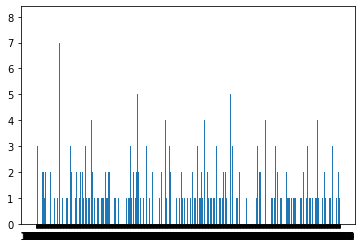

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(crossCheckDict)), list(crossCheckDict.values()), align='center')
plt.xticks(range(len(crossCheckDict)), list(crossCheckDict.keys()))
plt.show()

In [18]:
listOfVals = crossCheckDict.values()

In [19]:
len(listOfVals)

1018

On average how many similar related questions that stack exchange and our TFIDF model suggests

In [20]:
sum(listOfVals)/len(listOfVals)

0.8948919449901768

In [21]:
sum(listOfVals)

911

In [22]:
for key in bothRelatedAndSim.keys():
    print("https://ai.stackexchange.com/questions/" + str(key))
    print(bothRelatedAndSim[key])

https://ai.stackexchange.com/questions/13425
[(54, 0.178), (3176, 0.162)]
https://ai.stackexchange.com/questions/13432
[(2524, 0.127), (3453, 0.225)]
https://ai.stackexchange.com/questions/13434
[(1742, 0.109)]
https://ai.stackexchange.com/questions/13435
[(2381, 0.376), (3298, 0.432), (3702, 0.324)]
https://ai.stackexchange.com/questions/13443
[(2793, 0.312)]
https://ai.stackexchange.com/questions/13448
[(2127, 0.375), (1946, 0.487), (1488, 0.477), (3457, 0.544), (1318, 0.365)]
https://ai.stackexchange.com/questions/13449
[(3469, 0.12)]
https://ai.stackexchange.com/questions/13451
[(2911, 0.201)]
https://ai.stackexchange.com/questions/13460
[(2598, 0.169), (2672, 0.13)]
https://ai.stackexchange.com/questions/13473
[(3518, 0.293), (3040, 0.304), (1996, 0.459)]
https://ai.stackexchange.com/questions/13475
[(2236, 0.254), (1694, 0.329)]
https://ai.stackexchange.com/questions/13479
[(103, 0.315), (3875, 0.386)]
https://ai.stackexchange.com/questions/13482
[(3965, 0.448)]
https://ai.stacke

In [23]:
f = open("TFIDF_RELATEDDICT.txt", "a")
for key in bothRelatedAndSim:  
    f.write(str(key)+"\t"+str([i for i,j in bothRelatedAndSim[key]])+"\n")
f.close()

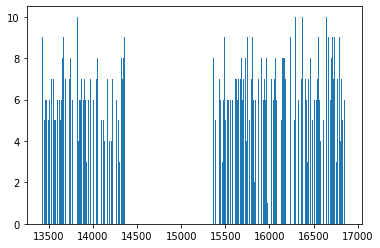

In [24]:
x = relatedId.keys()
bins = []

for key in x:
    bins.append(len(relatedId[key]))

width = bins[1] - bins[0]
plt.bar(x, bins, align='center', width=width)
plt.show()
